In [1]:
from typing import List, Any, Optional, Dict

import os
import re
import time
import json
import glob
import pickle
import random
import urllib
import requests
import subprocess
import concurrent.futures

import numpy as np

from bs4 import BeautifulSoup
from tqdm import tqdm
from pathlib import Path
from textblob import TextBlob
from threading import current_thread
from collections import Counter
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans

try:
    from libKMCUDA import kmeans_cuda
except:
    print("KM cuda not found, defaulting to sklearn CPU version of kmeans")
    kmeans_cuda = None

import utils
import embedding
import cluster_utils
import IDF_computation
from customdocument import CustomDocument

KM cuda not found, defaulting to sklearn CPU version of kmeans


<div class="alert alert-block alert-info"> 
We will run our term extraction on the Merged Approved Documents, the .pdf file can be found in the `data/` directory. For filtering of out-of-domain terms we will also process a set of EU regulations for medical device design, the .html files for these can be found in the same directory.
</div>

1. Preprocessing will consist only of removing headers/footers from PDF files. 

2. Candidate terms are identified using SPaR.txt (Kruiper et al., 2021), sentence splitting is done with the PunkSentTokenizer (Strunk, 2006).

3. Filtering of term candidates consists of:
  * a set of regular expressions found in utils.py
  * clustering of terms found in (1) the Approved Documents, and (2) a set of EU regulations for medical device design; any clusters containing terms from (2) will be designated as terms that are irrelevant to the AEC domain.
  
 


### 1 Preprocessing: get text from PDF and HTML

In [2]:
merged_approved_pdf_file = glob.glob("data/input/*.pdf")[0]
eu_html_files = glob.glob("data/input/*.html")
print(f"Approved Documents: {merged_approved_pdf_file}")
print(f"Reference corpus: {eu_html_files}")

Approved Documents: data/input/The Merged Approved Documents.pdf
Reference corpus: ['data/input/EUR-Lex - 31993L0042 - EN.html', 'data/input/CELEX 32017R0746 EN TXT.html', 'data/input/CELEX 32017R0745 EN TXT.html', 'data/input/EUR-Lex - 31998L0079 - EN.html', 'data/input/EUR-Lex - 31990L0385 - EN.html']


<div class="alert alert-block alert-info">
First we grab the text from the Merged Approved Documents pdf file. Our implementation on based on the pdf conversion pipeline in Haystack.
</div>

In [3]:
def read_pdf(file_path: Path, layout: bool = True, encoding: Optional[str] = "Latin1") -> List[str]:
        """
        Extract pages from the pdf file at file_path; based on Haystack.

        :param file_path: path of the pdf file
        :param layout: whether to retain the original physical layout for a page. If disabled, PDF pages are read in
                       the content stream order.
        """
        if layout:
            command = ["pdftotext", "-enc", encoding, "-layout", str(file_path), "-"]
        else:
            command = ["pdftotext", "-enc", encoding, str(file_path), "-"]
        output = subprocess.run(command, stdout=subprocess.PIPE, shell=False)  # type: ignore
        document = output.stdout.decode(errors="ignore")
        pages = document.split("\f")
        pages = pages[:-1]  # the last page in the split is always empty.
        return pages

def convert_pdf_to_mydoc(source_file_path: Path, 
                         output_file_path: Path, 
                         meta: Optional[Dict[str, str]] = None,
                         remove_header_and_footer: Optional[bool] = True,
                         clean_whitespace: Optional[bool] = True,
                         clean_empty_lines: Optional[bool] = True,
                         encoding: Optional[str] = "Latin1") -> CustomDocument:
        """
        Extract pages from the pdf file at file_path; based on Haystack.

        :param output_file_path:    Path to the .json file to store the converted file.
        :param source_file_path:    Path to the .pdf file you want to convert
        :param meta: Optional dictionary with metadata that shall be attached to all resulting documents.
                     Can be any custom keys and values.
        :param encoding: Encoding that will be passed as -enc parameter to pdftotext. "Latin 1" is the default encoding
                         of pdftotext. While this works well on many PDFs, it might be needed to switch to "UTF-8" or
                         others if your doc contains special characters (e.g. German Umlauts, Cyrillic characters ...).
                         Note: With "UTF-8" we experienced cases, where a simple "fi" gets wrongly parsed as
                         "xef\xac\x81c" (see test cases). That's why we keep "Latin 1" as default here.
                         (See list of available encodings by running `pdftotext -listenc` in the terminal)
        """
        pages = read_pdf(source_file_path, layout=True, encoding=encoding)

        if not pages:
            # empty input file
            return None
        
        pages = ["\n".join(p.splitlines()) for p in pages]

        # splitting text happens during preprocessing, so no split_size passed here;
        # split_size will be set to -1 during conversion.
        document = CustomDocument(output_file_path, source_file_path, split_size=-1)
        
        print("Converted PDF file to pages of text, combining to a single CustomDocument to keep track of page nrs.")
        for page_idx, page in tqdm(enumerate(pages)):
            
            # some simple cleaning -- roughly based on haystack.
            lines = page.splitlines()
            if remove_header_and_footer:
                # simplest way for removing header and footer 
                lines = lines[1:-2]

            if clean_whitespace:
                cleaned_lines = []
                for line in lines:
                    line = line.strip()
                    cleaned_lines.append(line)
                text = " ".join(cleaned_lines)

            if clean_empty_lines:
                text = re.sub(r"\n\n+", "\n\n", text)
                text = re.sub(r"[\s]+", " ", text)
            
            # no splitting here yet, so simply using page_nr as a place holder and split_id is left blank
            page_nr = str(page_idx + 1)
            document.add_content(text=text, 
                                 page_nr=page_nr, 
                                 doc_title=source_file_path.rsplit('/',1)[1])   # we're using the pdf file name for simplicity

        return document

In [4]:
merged_approved_document = convert_pdf_to_mydoc(merged_approved_pdf_file, "data/converted_documents/merged_approved.json")

Converted PDF file to pages of text, combining to a single CustomDocument to keep track of page nrs.


1274it [00:00, 7327.78it/s]


In [5]:
print(f"Maximum character length for a single block of text: {max([len(c.text) for c in merged_approved_document.all_contents])}")

Maximum character length for a single block of text: 5537


<div class="alert alert-block alert-info">
Second, we grab the text from the EU regulation HTML files. Because the text in HTML files isn't split into pages, the blocks of text are much longer.
</div>

In [6]:
def grab_HTML_text_simple(file):
    """
    All text in the EU htmls seems to be captured neatly in <p> tags, we don't care about structure currently.
    We do remove all unicode characters, see `utils.remove_unicode_chars()`.
    """ 
    with open(file, 'r') as f:
        text = f.read()
    soup = BeautifulSoup(text, 'html.parser')
    return [utils.remove_unicode_chars(x.text) for x in soup.body.find_all('p')]

In [7]:
def convert_html_to_mydoc(source_file_path: Path, 
                          output_file_path: Path) -> CustomDocument:
    
    document = CustomDocument(output_file_path, source_file_path, split_size=-1)
    document_paragraphs = []
    list_of_paragraphs = grab_HTML_text_simple(html_file)
    for paragraph in list_of_paragraphs:
        if paragraph.strip() != '':
            document_paragraphs.append(paragraph)
    
    for paragraph_idx, paragraph in tqdm(enumerate(document_paragraphs)):
            # no splitting here yet, so simply using page_nr as a place holder and split_id is left blank
            paragraph_nr = str(paragraph_idx + 1)
            document.add_content(text=paragraph, 
                                 page_nr=paragraph_nr, 
                                 doc_title=source_file_path) # we're using the html file name for simplicity
    return document

In [8]:
eu_regulation_documents = []
for html_file in tqdm(eu_html_files):
    outfile = f"data/converted_documents/{html_file.rsplit('/',1)[1]}.json"
    eu_regulation_documents.append(convert_html_to_mydoc(html_file, outfile))


  0%|                                                                                                                                                                               | 0/5 [00:00<?, ?it/s]
826it [00:00, 312172.92it/s]

4344it [00:00, 348442.47it/s]
 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 2/5 [00:00<00:01,  2.29it/s]
4799it [00:00, 362139.99it/s]
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 3/5 [00:01<00:01,  1.69it/s]
623it [00:00, 234228.34it/s]

511it [00:00, 263692.09it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.86it/s]


In [9]:
print(f"Maximum character length for a single paragraph: {max([len(c.text) for d in eu_regulation_documents for c in d.all_contents])}")

Maximum character length for a single paragraph: 143428


<div class="alert alert-block alert-info">
Third, if the output document doesn't exist (yet), we save the ConvertedDocument.
</div>

In [10]:
foreground_corpus = [merged_approved_document]
background_corpus = eu_regulation_documents

In [11]:
for d in foreground_corpus + background_corpus:
    if not os.path.exists(d.output_fp):
        d.write_document()

### 2 Term extraction: identify object spans with SPaR.txt

<div class="alert alert-block alert-info">
For each of the contents in a document, run SPaR.txt for object identification. To this end, we split the text into sentences and pass a sentence to a running instance fo a SPaR.txt predictor.
</div>



In [12]:
# download SPaR.txt if required
if not os.path.exists("SPaR.txt/README.md"):
    !git clone https://github.com/rubenkruiper/SPaR.txt.git

In [13]:
import imp
with open('SPaR.txt/spar_predictor.py', 'rb') as fp:
    spar_predictor = imp.load_module(
        'spar_predictor', fp, 'SPaR.txt.spar_predictor.py',
        ('.py', 'rb', imp.PY_SOURCE)
    )

In [14]:
# trains a model if needed, otherwise loads from archive; 
# - best F1 on dev/validation in the paper is 80,96 trained on a GPU, CPU will be a bit lower ~77.x I think
sp = spar_predictor.SparPredictor()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
example = "An example sentence to show how ACC terminology will be extracted from the British Standards."
start_time = time.time()
# prepare instance and run model on single instance
docid = ''                  # ToDo - add doc_id during pre_processing?
token_list = sp.predictor._dataset_reader.tokenizer.tokenize(example)
instance = sp.predictor._dataset_reader.text_to_instance(docid,
                                                      example,
                                                      token_list,
                                                      sp.predictor._dataset_reader._token_indexer)
result = sp.predictor.predict_instance(instance)
printable_result = sp.parse_output(result, ['obj'])
print(printable_result)
print("Parsing took {}".format(time.time() - start_time))

{'obj': ['An example sentence', 'ACC terminology', 'the British Standards']}
Parsing took 0.11192679405212402


In [16]:
# These should automatically run on your Nvidia GPU if available
class SparInstance:
    def __init__(self):
        self.sp = spar_predictor.SparPredictor()
    
    def call(self, input_str:str=''):
        if input_str:
            # prepare instance and run model on single instance
            docid = ''  # ToDo - add doc_id during pre_processing?
            token_list = self.sp.predictor._dataset_reader.tokenizer.tokenize(input_str)

            # truncating the input to SPaR.txt to maximum 512 tokens
            token_length = len(token_list)
            if token_length > 512:
                token_list = token_list[:511] + [token_list[-1]]
                token_length = 512

            instance = self.sp.predictor._dataset_reader.text_to_instance(docid, input_str, token_list,
                                                              self.sp.predictor._dataset_reader._token_indexer)
            result = self.sp.predictor.predict_instance(instance)
            printable_result = self.sp.parse_output(result, ['obj'])
            return {
                    "prediction": printable_result,
                    "num_input_tokens": token_length,
            }
            
        # If the input is None, or too long, return an empty list of objects
        return {
                "prediction": {'obj': []},
                "num_input_tokens": 0
            }


In [17]:
class TermExtractor:
    
    def __init__(self, split_length=300, max_num_cpu_threads=4):
        """
        Initialise SPaR.txt predictors `max_num_cpu_threads` 
        """
        self.split_length = split_length   # in number of tokens
        self.max_num_cpu_threads = max_num_cpu_threads
        self.PREDICTORS = []
        for i in range(max_num_cpu_threads + 1):
            self.PREDICTORS.append(SparInstance())
    
    
    def process_sentence(self, sentence: str = ''):
        """
        """
        predictor_to_use = int(current_thread().name.rsplit('_', 1)[1])
        spartxt = self.PREDICTORS[predictor_to_use]

        # SPaR doesn't handle ALL uppercase sentences well, which the OCR system sometimes outputs    
        sentence = sentence.lower() if sentence.isupper() else sentence
        prediction_dict =  spartxt.call(sentence)
        if not prediction_dict:
            return []

        pred_labels = prediction_dict["prediction"]
        return pred_labels['obj']
        

    def split_into_sentences_and_run_spar(self, input_document):
        """
        """
        print(f"Working on: {input_document.source_fp}")
        content_as_list_of_dicts = input_document.to_list_of_dicts()
        total_number_of_sentences_found = 0
        content_idx = 0
        for content_dict in tqdm(content_as_list_of_dicts):

            text = ' '.join([x for x in content_dict["content"].split(' ') if x != ''])
            # some really long paragraphs in the EU regulations are summations that should be split at ';'
            if len(text) > 3000:
                text = text.replace(";", ".\n")

            # We'll split into sentences even if this has been done before, it doesn't take long
            sentences = []
            for part in text.split('\n'):
                # split into sentences using PunktSentTokenizer (TextBlob implements NLTK's version under the hood) 
                sentences += [str(s) for s in TextBlob(part).sentences if len(str(s)) > 10]

            content_dict["meta"]["sentences"] = '###'.join(sentences)
                
            total_number_of_sentences_found += len(sentences)

            # process sentences in the content and add SPaR.txt object tags to the content dict.        
            if not content_dict["meta"]["SPaR_labels"]:
                with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_num_cpu_threads) as executor:
                    futures = [executor.submit(self.process_sentence, sentences[idx]) for idx in range(len(sentences))]

                content_spar_objects = [f.result() for f in futures]
                content_dict["meta"]["SPaR_labels"] = ', '.join([tag for tags in content_spar_objects for tag in tags])
                
            # immediately update the list of content_dicts and every X iterations we save the file 
            content_as_list_of_dicts[content_idx] = content_dict
            if content_idx // 5 == 0:
                converted_document.replace_contents(content_as_list_of_dicts)
                converted_document.write_document()
            
            content_idx += 1

        print(f"Number of sentences found: {total_number_of_sentences_found}")
        converted_document.replace_contents(content_as_list_of_dicts)
        converted_document.write_document()
        

In [18]:
te = TermExtractor()

In [19]:
# Run SPaR.txt on all documents and write to file
for converted_document in foreground_corpus + background_corpus:
    # re-load the document from file, to make sure we don't overwrite existing SPaR.txt labels
    converted_document = converted_document.load_document(converted_document.output_fp)
    te.split_into_sentences_and_run_spar(converted_document)
    

Working on: data/input/The Merged Approved Documents.pdf


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1274/1274 [00:01<00:00, 784.58it/s]


Number of sentences found: 17745
Working on: data/input/EUR-Lex - 31993L0042 - EN.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 826/826 [00:00<00:00, 3916.79it/s]


Number of sentences found: 1679
Working on: data/input/CELEX 32017R0746 EN TXT.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4344/4344 [00:01<00:00, 2691.12it/s]


Number of sentences found: 3405
Working on: data/input/CELEX 32017R0745 EN TXT.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4799/4799 [00:01<00:00, 3377.10it/s]


Number of sentences found: 3838
Working on: data/input/EUR-Lex - 31998L0079 - EN.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 623/623 [00:00<00:00, 2808.78it/s]


Number of sentences found: 1255
Working on: data/input/EUR-Lex - 31990L0385 - EN.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 5005.35it/s]

Number of sentences found: 771


<div class="alert alert-block alert-info">
Number of sentences (longer than 10 characters) found in: <ul>
    <li>Merged Approved documents: 17745</li>
    <li>Background corpus (1679+3405+3838+1255+771): 10948</li>
    </ul>
</div>

### 3 Filtering

<div class="alert alert-block alert-info">
First, load all terms from the processed files.
</div>

In [20]:
foreground_terms_lists = [c.NER_labels for d in foreground_corpus for c in d.load_document(d.output_fp).all_contents]
foreground_terms = [t for t_list in foreground_terms_lists for t in t_list if t]
foreground_terms_c = Counter(foreground_terms)
print(f"Total number of foreground terms: {len(foreground_terms)}")
print(f"Total number of UNIQUE foreground terms: {len(foreground_terms_c)}")
foreground_terms_c.most_common(10)

Total number of foreground terms: 114333
Total number of UNIQUE foreground terms: 42657


[('the', 2130),
 ('a', 930),
 ('the building', 864),
 ('buildings', 839),
 ('guidance', 522),
 ('a building', 455),
 ('the Building Regulations', 434),
 ('document', 303),
 ('people', 301),
 ('the requirements', 297)]

In [21]:
background_terms_lists = [c.NER_labels for d in background_corpus for c in d.load_document(d.output_fp).all_contents]
background_terms = [t for t_list in background_terms_lists for t in t_list if t]
background_terms_c = Counter(background_terms)
print(f"Total number of background terms: {len(background_terms)}")
print(f"Total number of UNIQUE background terms: {len(background_terms_c)}")
background_terms_c.most_common(10)

Total number of background terms: 73124
Total number of UNIQUE background terms: 10245


[('the', 2651),
 ('devices', 1641),
 ('the manufacturer', 1243),
 ('the device', 1187),
 ('Regulation', 624),
 ('the notified body', 595),
 ('information', 550),
 ('Member States', 489),
 ('a', 451),
 ('the market', 447)]

In [22]:
print(f"Total number of unique spans identified by SPaR.txt:{len(foreground_terms_c+background_terms_c)}")

Total number of unique spans identified by SPaR.txt:51296


<div class="alert alert-block alert-info">
Second, clean the terms with the regular expressions we've defined in utils.py
</div>

In [23]:
regex_filter = utils.RegexFilter()
def run_filters(input_counter):
    cleaned_counter = Counter()
    for k, v in input_counter.items():
        # terms should occur twice at least
        if v < 2:
            continue

        # todo; clean up these util functions and how to call them|
        _, k = regex_filter.run_filter(k)
        if k:
            cleaned_k = utils.custom_cleaning_rules(k)
            if cleaned_k:
                cleaned_counter[cleaned_k[0]] = v
    return cleaned_counter

In [24]:
cleaned_foreground_terms_c = run_filters(foreground_terms_c)
print(len(cleaned_foreground_terms_c))
cleaned_foreground_terms_c.most_common(10)

11202


[('guidance', 522),
 ('a building', 455),
 ('document', 303),
 ('the requirements', 297),
 ('requirements', 266),
 ('work', 242),
 ('the guidance', 240),
 ('the work', 232),
 ('Schedule 1', 226),
 ('the dwelling', 215)]

In [25]:
cleaned_background_terms_c = run_filters(background_terms_c)
print(len(cleaned_background_terms_c))
cleaned_background_terms_c.most_common(10)

6191


[('devices', 1641),
 ('the device', 1187),
 ('the notified body', 595),
 ('Member States', 489),
 ('accordance', 429),
 ('a device', 405),
 ('conformity', 357),
 ('the requirements', 350),
 ('The notified body', 328),
 ('notified bodies', 324)]

<div class="alert alert-block alert-info">
Third, we cluster the embeddings for both foreground and background terms with KMeans.
</div>


* Note: embeddings will be IDF weighted (IDF weights over both foreground and background corpora)
  * Could add more sentences to the computation of IDF weights, e.g., definitions from vocabularies/WikiData.

In [26]:
# Which tokenizer to use for IDF computation and Embedding;
bert_model_name = 'bert-base-cased'

In [27]:
all_terms_c = cleaned_foreground_terms_c + cleaned_background_terms_c

In [28]:
len(all_terms_c)

16458

In [29]:
all_terms_c.most_common(10)

[('devices', 1665),
 ('the device', 1195),
 ('the requirements', 647),
 ('accordance', 631),
 ('the notified body', 595),
 ('guidance', 539),
 ('Member States', 491),
 ('requirements', 457),
 ('a building', 455),
 ('a device', 412)]

In [30]:
# some insight in number of MWEs
mwes = []
for t in all_terms_c.keys():
    words = t.split(' ')
    if words[0] in ['the', 'a', 'The', 'A', 'an', 'An', 'any', 'Any', 'this', 'This']:
        words = words[1:]
    if len(words) > 1:
        mwes.append(t)

print(f"Number of MWEs: {len(mwes)}")
random.sample(mwes, 10)


Number of MWEs: 10850


['The Building Approved Inspectors',
 'paragraph 6 18',
 'low - lying sites',
 'emergency escape lighting process lighting',
 'severe deterioration',
 'firefighting stairs',
 'the rafter members',
 'blood products',
 'No 45 / 2001',
 'an external stair']

In [31]:
# Compute IDF weights
sentence_lists = [c.sentences for d in foreground_corpus + background_corpus for c in d.load_document(d.output_fp).all_contents]
all_sentences = [s for sent_list in sentence_lists for s in sent_list if s]

In [32]:
print(len(all_sentences))
all_sentences[:10]

28693


['The Merged Approved Documents',
 'How to use the Merged Approved Documents This document combines the approved documents into a single PDF.',
 'Each approved document is self-contained and has its own introduction.',
 'Each introduction relates only to the corresponding approved document.',
 "Each introduction also contains information on when the document's guidance came into effect (or will come into effect).",
 'It is important to check that the version of each approved document you are using remains current and is the correct version for your project.',
 'Please refer to the Ministry of Housing, Communities and Local Government website to check, and confirm with your building control body if in doubt.',
 'Key features The Merged Approved Documents enable the user to: undertake a word search across all of the approved documents cut and paste text and diagrams into other documents add notes to a saved copy use an index to access individual sections of the guidance Correction to App

In [33]:
IDF_c = IDF_computation.IdfComputer("data/IDF_weights.json", bert_model_name=bert_model_name)
IDF_path = IDF_c.compute_or_load_IDF_weights(all_sentences, overwrite=False)

Loading existing IDF weights.
Printing some IDF values, should be subword units!
['cluster']
['##of']
['deposits']
['ultimate']
['horizontal']
['proximity']
['estates']
['exploration']
['##most']
['rendered']


In [34]:
# Embed each of the terms identified by SPaR.txt, applies IDF weights

In [35]:
all_terms = [k for k in all_terms_c.keys()] # counter keys, so already unique
print(f"Number of unique terms: {len(all_terms)}")
all_terms[:10]

Number of unique terms: 16458


['the Merged Approved Documents',
 'document',
 'documents',
 'Each introduction',
 'approved',
 'information',
 'guidance',
 'the version',
 'project',
 'the Ministry']

In [36]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name, output_hidden_states=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
embedder = embedding.Embedder(tokenizer, bert_model, 
                              IDF_dict=json.load(open(IDF_path)), 
                              embedding_fp="output/",
                              layers_to_use = [12],         # we'll use the output of the last layer
                              layer_combination = "avg",    # how to combine layers if multiple are used
                              idf_threshold = 1.5,          # minimum IDF value for a token to contribute
                              idf_weight_factor = 1.0,      # modify how strong the influence of IDF weighting is
                              not_found_idf_value = 0.5)    # IDF value for tokens that weren't seen during IDF computation (doesn't apply here)

In [38]:
# Compute the embeddings, this is split into subsets so we don't overload your memory (adjust these values if needed)
max_num_cpu_threads = 4
subset_size = 1000

# Checks which of the embeddings for the clustering cluster_data already exist, so they can be re-used
term_subsets = utils.split_list(all_terms, subset_size)
embedding_files = glob.glob(embedder.embedding_fp + 'embeddings*.pkl')
span_and_embedding_pairs = []
if len(embedding_files) == len(term_subsets):
    for e in embedding_files:
        span_and_embedding_pairs += pickle.load(open(e, 'rb'))
else:
    print(f"Preparing embeddings for {len(all_terms)} spans, in groups of: {subset_size}")
    subset_idx = 0            # iterator index outside of tqdm 
    for subset in tqdm(term_subsets):
        subset_embeddings = []
        subset_file_name = embedder.embedding_fp + "embeddings_part_" + '{}.pkl'.format(subset_idx)
        subset_idx += 1
        if os.path.exists(subset_file_name):
            # already computed previously
            continue
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_num_cpu_threads) as executor:
            futures = [executor.submit(embedder.embed_a_span, subset[idx]) for idx in range(len(subset))]

        subset_embeddings += [f.result() for f in futures if f.result()]

        with open(subset_file_name, 'wb') as f:
            pickle.dump(subset_embeddings, f)

    # Once all embeddings are created; combine them in span_and_embedding_pairs
    embedding_files = glob.glob(embedder.embedding_fp + "embeddings_part_" + '*.pkl')
    for e in embedding_files:
        span_and_embedding_pairs += pickle.load(open(e, 'rb'))

In [39]:
# Create a single file with all embeddings, in the meantime standardising the embeddings to improve the representation
print(f"Normalising and combining computed/existing {len(embedding_files)} embeddings from files into single file")
unique_spans, unique_embeddings = zip(*span_and_embedding_pairs)
with open(embedder.embedding_fp + "unique_spans.pkl", 'wb') as f:
    pickle.dump(unique_spans, f)

with open(embedder.embedding_fp + "unique_embeddings.pkl", 'wb') as f:
    # we average over the token embeddings in a term
    unique_clustering_data = np.stack([np.mean(e, axis=0) if len(e.shape) > 1 else e for e in unique_embeddings])

    # standardise the unique clustering data, as suggested by https://github.com/wtimkey/rogue-dimensions
    embedder.emb_mean = unique_clustering_data.mean(axis=0)
    embedder.emb_std = unique_clustering_data.std(axis=0)
    pickle.dump(embedder.emb_mean, open(embedder.embedding_fp + "standardisation_mean.pkl", 'wb'))
    pickle.dump(embedder.emb_std, open(embedder.embedding_fp + "standardisation_std.pkl", 'wb'))

    standardised_clustering_data = (unique_clustering_data - embedder.emb_mean) / embedder.emb_std

    pickle.dump(standardised_clustering_data, f)
    
# COULD/SHOULD remove the embedding files now

Normalising and combining computed/existing 17 embeddings from files into single file


In [40]:
# functions to compute clusters on either CPU or GPU
def compute_clusters_sklearn(unique_clustering_data, cluster_model_fp, num_clusters=10):
    """
    Note that this clustering function relies on the CPU. It won't be able to compute clusters for large 
    amounts of inputs, e.g., 100.000 spans. When using a large number of clusters (e.g. 5000) it is also
    a lot slower than a GPU implementation for. Or it may simply not converge! 
    For large inputs/num_clusters you'll need to use compute_clusters_kmcuda, and have access to a GPU.
    """
    print(f"Computing {num_clusters} clusters from scratch, using sklearn on the CPU")
    start_time = time.time()
    sklearn_kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=3, n_init=1, random_state=14,
                            tol=0.0001, verbose=0)
    assignments = sklearn_kmeans.fit_predict(unique_clustering_data)
    centroids = sklearn_kmeans.cluster_centers_
    print("Clustering took {}".format(time.time() - start_time))
    with open(cluster_model_fp, 'wb') as f:
        pickle.dump((centroids, assignments), f)
        
# compute clusters on CPU for now
def compute_clusters_kmcuda(unique_clustering_data, cluster_model_fp, num_clusters=10000):
    """
    Won't implement cosine KMeans here, as I want to predict with sklearn in this notebook. 
    Also not sure if the results are really that much better.
    """
    centroids, assignments = kmeans_cuda(unique_clustering_data, num_clusters, init="k-means++",
                                                 verbosity=1, seed=14) # , device=0)
    with open(cluster_model_fp, 'wb') as f:
        pickle.dump((centroids, assignments), f)

In [41]:
if not kmeans_cuda:
    # Computing clusters on the CPU
    for num_clusters in range(2000,8001, 500):
        cluster_file = f"output/sklearn_{num_clusters}_clusters.pkl"
        if not os.path.exists(cluster_file):
            compute_clusters_sklearn(standardised_clustering_data, cluster_file, num_clusters)
        else:
            print(f"sklearn cluster file exists for {num_clusters} clusters")
else:     
    for num_clusters in range(4000,10001, 500):
        cluster_file = f"output/kmcuda_{num_clusters}_clusters.pkl"
        if not os.path.exists(cluster_file):
            compute_clusters_kmcuda(standardised_clustering_data, cluster_file, num_clusters) 
        else:
            print(f"kmcuda cluster file exists for {num_clusters} clusters")

sklearn cluster file exists for 2000 clusters
sklearn cluster file exists for 2500 clusters
sklearn cluster file exists for 3000 clusters
sklearn cluster file exists for 3500 clusters
sklearn cluster file exists for 4000 clusters
sklearn cluster file exists for 4500 clusters
sklearn cluster file exists for 5000 clusters
sklearn cluster file exists for 5500 clusters
sklearn cluster file exists for 6000 clusters
sklearn cluster file exists for 6500 clusters
sklearn cluster file exists for 7000 clusters
sklearn cluster file exists for 7500 clusters
sklearn cluster file exists for 8000 clusters


* Select the 'best' cluster model using Elbow and Silhouette

In [42]:
clustering_type = "sklearn"
clustering_files = glob.glob(f'output/{clustering_type}_*.pkl')

Computing elbow and silhouette (if not too many num_clusters) scores.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1672.85it/s]

Loading values from existing csv file: output/sklearn_4500_clusters.pkl
Loading values from existing csv file: output/sklearn_5000_clusters.pkl
Loading values from existing csv file: output/sklearn_3500_clusters.pkl
Loading values from existing csv file: output/sklearn_2000_clusters.pkl
Loading values from existing csv file: output/sklearn_2500_clusters.pkl
Loading values from existing csv file: output/sklearn_3000_clusters.pkl
Loading values from existing csv file: output/sklearn_5500_clusters.pkl
Loading values from existing csv file: output/sklearn_4000_clusters.pkl
Loading values from existing csv file: output/sklearn_7500_clusters.pkl
Loading values from existing csv file: output/sklearn_6000_clusters.pkl
File may not have the right naming format: output/sklearn_clusters.pkl
Loading values from existing csv file: output/sklearn_6500_clusters.pkl
Loading values from existing csv file: output/sklearn_7000_clusters.pkl
Loading values from existing csv file: output/sklearn_8000_cluste

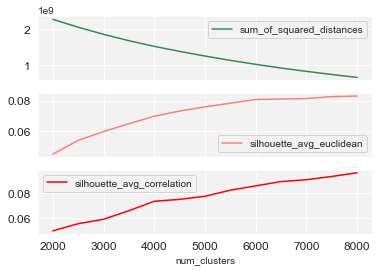

In [43]:
# This takes a bit of time; 6-10 minutes per cluster size for 2000-6000 clusters 
# but resulting scores are saved in a csv and reused
clustering_data_fp = "output/"
es = cluster_utils.ElbowAndSilhouette(clustering_data_fp)
es.compute_scores_for_models(clustering_type, clustering_files)

* Based on the number of clusters we'd like to use, we create a lookup-dictionary for the embedding and assigned cluster of each span

In [56]:
chosen_num_clusters = 6000
cluster_model_to_use = f'output/{clustering_type}_{chosen_num_clusters}_clusters.pkl'

In [57]:
centroids, assignments = pickle.load(open(cluster_model_to_use, 'rb'))

unique_background_terms = [k for k in background_terms_c.keys()]
cluster_dict_creator = cluster_utils.ClusterDict(unique_background_terms, unique_spans, unique_embeddings, 
                 centroids, 
                 assignments,
                 embedding_fp="output/")

In [58]:
phrase_cluster_dict, clusters_to_filter = cluster_dict_creator.prep_cluster_dict(chosen_num_clusters)

Computing the cluster dictionary.


In [59]:
# print some insight in the clusters
max_terms_to_show = 5
for k in random.sample(phrase_cluster_dict.keys(), 10):
    some_terms = [span for score, span in phrase_cluster_dict[k]]
    if k in clusters_to_filter:
        print(f"Filtered: {some_terms[:max_terms_to_show]}")
    else:
        print(f"AEC domain: {some_terms[:max_terms_to_show]}")

AEC domain: ['the stairway', 'the ladder', 'a ladder', 'a switch']
AEC domain: ['the worktop', 'worktop', 'kitchen worktop']
AEC domain: ['the subsoil', 'subsoils']
AEC domain: ['layout']
AEC domain: ['surcharging']
Filtered: ['the designation', 'the name', 'The designation', 'The name', 'his name']
Filtered: ['the relevant']
AEC domain: ['heat loss', 'heat losses', 'heat gain', 'heat gains']
AEC domain: ['execution']
AEC domain: ['seats']


/var/folders/lp/l_mzhpjs6bg95plfkl_n_vsc0000gn/T/ipykernel_22386/378847011.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for k in random.sample(phrase_cluster_dict.keys(), 10):


In [60]:
removed_terms = [span for k, v in phrase_cluster_dict.items() for score, span in v if k in clusters_to_filter]

In [61]:
filtered_terms = [t for t in removed_terms if t in foreground_terms]

In [62]:
domain_terms = [span for k, v in phrase_cluster_dict.items() for score, span in v  if k not in clusters_to_filter]

In [63]:
print(len(filtered_terms))
print("Terms that were filtered:")
random.sample(filtered_terms,10)

3703
Terms that were filtered:


['circuits',
 'components',
 'control equipment',
 'member',
 'a inside face',
 'the detailed design',
 'local authorities',
 'common',
 'section of',
 'background ventilators']

In [64]:
print(len(domain_terms))
print("Terms that were kept:")
random.sample(domain_terms,10)

7782
Terms that were kept:


['suspended concrete floor',
 'the physical property',
 'parapet gutters',
 'oil pollution',
 'Parts F J',
 'Department',
 'veranda',
 'Approved Document C',
 'a fire and rescue service pumping appliance',
 'floor floor']

In [67]:
# cluster avg nr of items
np.max([len(v) for v in phrase_cluster_dict.values()])

53

In [73]:
[v for v in phrase_cluster_dict.values() if len(v) == 1]

[[[1282.649658203125, 'consumption']],
 [[4366.1826171875, 'feasibility']],
 [[2603.40673828125, 'MTP']],
 [[2987.36181640625, 'Rainwater']],
 [[1577.7880859375, 'wells']],
 [[1875.974853515625, 'the optional requirement']],
 [[3671.099609375, 'person per day']],
 [[2652.797607421875, 'the planning permission']],
 [[2817.74365234375, 'white goods']],
 [[1042.362548828125, 'the methodology']],
 [[3455.48583984375, 'person / day']],
 [[816.0550537109375, 'the target']],
 [[4821.2568359375, 'UPPLY']],
 [[8007.8076171875, 'SYSTEMS']],
 [[800.4744873046875, 'the outlet']],
 [[718.946044921875, 'the application']],
 [[2033.6915283203125, 'the stored water']],
 [[7189.8779296875, 'cistern lids']],
 [[3542.37890625, 'Unvented']],
 [[6759.2998046875, 'Calorifiers']],
 [[2338.06396484375, 'the operating pressure']],
 [[876.7068481445312, 'the boiler']],
 [[7913.62109375, 'WARNING']],
 [[1315.650390625, 'TO']],
 [[2338.38232421875, 'Particular']],
 [[843.3309326171875, 'the choice']],
 [[5478.221